In [0]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import warnings
import tensorflow as tf
import random
import scipy
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, MaxPool3D, Dropout, \
        Flatten, Conv3DTranspose, UpSampling3D, Reshape, Input, concatenate
from tensorflow.keras.regularizers import l1_l2
from google.colab import drive

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [62]:
import tensorflow as tf
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


#### Create Train/Test Subset

In [63]:
%cd /content/drive/My Drive/AD_MRI

# Load list of records
with open('AD_MRI_Master', 'rb') as f:
    master_list = pickle.load(f)
    
master_sheet = pd.DataFrame.from_dict(master_list, orient='index')
display(master_sheet.head())
print()

# Split: 81% train, 10% validation, 10% test
train_list, val_list, train_label, val_label = \
        train_test_split(master_sheet.subject.values, 
                         master_sheet.diagnosis.values, 
                         random_state = 1337, 
                         test_size=0.10)
        
train_list,test_list,train_label,test_label = \
        train_test_split(train_list, 
                         train_label, 
                         random_state = 0, 
                         test_size=0.10)

# Check for ratios of AD to NC to be consistent among sets
AD_count = 0
for lab in train_label:
    if lab == 'AD':
        AD_count +=1
print('train_ratio AD: ', round(AD_count/len(train_label), 3))

AD_count = 0
for lab in val_label:
    if lab == 'AD':
        AD_count +=1
print('val_ratio AD: ', round(AD_count/len(val_label), 3))

AD_count = 0
for lab in test_label:
    if lab == 'AD':
        AD_count +=1
print('test_ratio AD: ', round(AD_count/len(test_label), 3))

print('\nNumber of records\ntrain:', len(train_list), 
      '\nvalidation:', len(val_list), '\ntest:', len(test_list))




/content/drive/My Drive/AD_MRI


,subject,age,diagnosis,scan_ID
OAS30001,OAS30001,65.0,CN,OAS30001_MR_d0129
OAS30002,OAS30002,68.0,CN,OAS30002_MR_d0371
OAS30003,OAS30003,60.0,CN,OAS30003_MR_d0558
OAS30004,OAS30004,58.0,CN,OAS30004_MR_d1101
OAS30005,OAS30005,48.0,CN,OAS30005_MR_d0143



train_ratio AD:  0.367
val_ratio AD:  0.367
test_ratio AD:  0.371

Number of records
train: 793 
validation: 98 
test: 89


### Create Generator

In [0]:
processed_dir = '/content/drive/My Drive/AD_MRI/PROCESSED/'

# custom data generator.
import random
import scipy
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import random

import scipy


def labels_to_categorical(labels):
    le = LabelEncoder()
    le.fit(["CN", "AD"])
    num_lab=to_categorical(le.transform(labels),num_classes=2)
    return num_lab

def my_minmax(z):
    return (z-np.min(z))/(np.max(z)-np.min(z))

# Custom data generator
class MyDataGenerator(Sequence):
    """Generates data for Keras Sequence based data generator. 
    Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, processed_dir, augment=False, 
                 to_fit=True, batch_size=32, dim=(120, 160, 120, 1),
                 n_classes=2, shuffle=True, ventricles_only=True, 
                 slice_start=50, slice_end=66, sample_weight=None):
        """Initialization
        :param list_IDs: list of all 'label' PATHS
        :param processed_dir: path to directory of processed images
        :param augment
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        :param ventricles_only: reduce dimensions to relevant slice
        """
        self.list_IDs = list_IDs
        self.processed_dir = processed_dir
        self.augment = augment
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.ventricles_only = ventricles_only
        self.on_epoch_end()
        self.slice_start = slice_start
        self.slice_end = slice_end
        if self.ventricles_only == False:
            self.slice_size = 120
        else:
            self.slice_size = slice_end - slice_start
        self.sample_weight = sample_weight
        # sample_weight needs to be provided if to_fit=True


    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index 
                               * self.batch_size:(index + 1) 
                               * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        # Generate data
        X, y = self._load_data(list_IDs_temp)
        X = my_minmax(np.float32(X))
        if self.ventricles_only == True:
          X = X[:, :, :, self.slice_start:self.slice_end, :]
          w_temp = np.asarray([self.sample_weight[k] for k in indexes])
        if self.to_fit:
            y = {'CAE_classifier': y, 'CAE_decoder': X}
            w = {'CAE_classifier': w_temp,
                 'CAE_decoder':np.ones(np.shape(X))}
            return X, y, w
        else:
            return X


    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def _load_data(self, list_IDs_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            # start X
            with open(self.processed_dir+ID+'_data','rb') as f:
                data = pickle.load(f)
                
            # third dimension = 120, error using self.slice_size for value 16
            x_reshape= np.reshape(data['image'], (120, 160, 120, 1))
            if self.augment == True:
                x_reshape = scipy.ndimage.rotate(x_reshape, 
                                axes=random.choice([(0, 1), (0, 2), (1, 2)]), 
                                angle=random.choice([360-15, 15,0]), 
                                reshape=False)
            X[i,] = x_reshape
            
            #start y
            y[i,] = labels_to_categorical([data['diagnosis']])

        return X, y

    

In [65]:
print(labels_to_categorical(["CN"]))

balancing_weights = class_weight.compute_sample_weight('balanced',train_label)
print(balancing_weights[0],train_label[0])
print(balancing_weights[1],train_label[1])


# usage:
processed_dir = '/content/drive/My Drive/AD_MRI/PROCESSED/'
mdg = MyDataGenerator(test_list, processed_dir, to_fit=True, augment=True, 
                      sample_weight=balancing_weights,batch_size=2)

#X, pred, weights = mdg.__getitem__(0) #without .__getitem__ obviously



[[0. 1.]]
1.3625429553264605 AD
0.7898406374501992 CN


##### --- Start adaptation from Arezoo's notebook ---

#### Building CAE Encoder

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, MaxPool3D, Dropout, \
    Flatten, Conv3DTranspose, UpSampling3D, Reshape
from tensorflow.keras.layers import Input


In [67]:
dropout_rate = 0.5
input_img = Input(shape=(120, 160, 16, 1), name='Input')
print('\ninput shape:', input_img.shape)

x = Conv3D(10, (3, 3, 3), activation='relu', padding='same', 
           name='Convolution_1')(input_img)
x = MaxPool3D((2, 2, 2), name='MaxPooling_1')(x)
x = Dropout(dropout_rate, name='DropOut_1')(x)

x = Conv3D(10, (3, 3, 3), activation='relu', padding='same', 
           name='Convolution_2')(x)
x = MaxPool3D((2, 2, 2), name='MaxPooling_2')(x)
x = Dropout(dropout_rate, name='DropOut_2')(x)

x = Conv3D(10, (3, 3, 3), activation='relu', padding='same', 
           name='Convolution_3')(x)
x = MaxPool3D((2, 2, 2), name='MaxPooling_3')(x)
x = Dropout(dropout_rate, name='DropOut_3')(x)

encoded = x
encoded_shape = K.int_shape(encoded)
print('output shape:', encoded_shape, '\n')

CAE_encoder = Model(input_img, encoded, name='CAE_encoder')
CAE_encoder.summary()




input shape: (None, 120, 160, 16, 1)
output shape: (None, 15, 20, 2, 10) 

Model: "CAE_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 120, 160, 16, 1)] 0         
_________________________________________________________________
Convolution_1 (Conv3D)       (None, 120, 160, 16, 10)  280       
_________________________________________________________________
MaxPooling_1 (MaxPooling3D)  (None, 60, 80, 8, 10)     0         
_________________________________________________________________
DropOut_1 (Dropout)          (None, 60, 80, 8, 10)     0         
_________________________________________________________________
Convolution_2 (Conv3D)       (None, 60, 80, 8, 10)     2710      
_________________________________________________________________
MaxPooling_2 (MaxPooling3D)  (None, 30, 40, 4, 10)     0         
_____________________________________________

#### Building CAE Decoder

In [68]:
encoded_shape

(None, 15, 20, 2, 10)

In [69]:
encoded_input = Input(shape=(encoded_shape[1],encoded_shape[2], 
                             encoded_shape[3], encoded_shape[4],), 
                      name='Encoded')

print('\ninput shape:', encoded_input.shape)
x = encoded_input

x = Conv3DTranspose(10, (3, 3, 3), activation='relu', padding='same', 
                    name='Convolution_3')(x)
x = UpSampling3D((2, 2, 2), name='UpSampling_3')(x)
x = Dropout(dropout_rate, name='DropOut_3')(x)

x = Conv3DTranspose(10, (3, 3, 3), activation='relu', padding='same', 
                    name='Convolution_2')(x)
x = UpSampling3D((2, 2, 2), name='UpSampling_2')(x)
x = Dropout(dropout_rate, name='DropOut_2')(x)

x = Conv3DTranspose(10, (3, 3, 3), activation='relu', padding='same', 
                    name='Convolution_1')(x)
x = UpSampling3D((2, 2, 2), name='UpSampling_1')(x)
x = Dropout(dropout_rate, name='DropOut_1')(x)

decoded = Conv3DTranspose(1, (3, 3, 3), activation='sigmoid', padding='same', 
                          name='Output')(x)

print('output shape:', K.int_shape(decoded), '\n')

CAE_decoder = Model(encoded_input, decoded, name='CAE_decoder')
CAE_decoder.summary()



input shape: (None, 15, 20, 2, 10)
output shape: (None, 120, 160, 16, 1) 

Model: "CAE_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoded (InputLayer)         [(None, 15, 20, 2, 10)]   0         
_________________________________________________________________
Convolution_3 (Conv3DTranspo (None, 15, 20, 2, 10)     2710      
_________________________________________________________________
UpSampling_3 (UpSampling3D)  (None, 30, 40, 4, 10)     0         
_________________________________________________________________
DropOut_3 (Dropout)          (None, 30, 40, 4, 10)     0         
_________________________________________________________________
Convolution_2 (Conv3DTranspo (None, 30, 40, 4, 10)     2710      
_________________________________________________________________
UpSampling_2 (UpSampling3D)  (None, 60, 80, 8, 10)     0         
_____________________________________________

In [70]:
# ICAE Classifier

encoded_input = Input(shape=(encoded_shape[1], encoded_shape[2], 
                             encoded_shape[3], encoded_shape[4],), 
                      name='Encoded')

y = encoded_input

y = Flatten(name='Flatten')(y)
y = Dense(1024, activation='selu', name='SELU_1')(y)
y = Dense(64, activation='selu', name='SELU_2')(y)
y = Dense(2, activation='softmax', name='Prediction')(y)

CAE_pred = y

CAE_classifier = Model(encoded_input, CAE_pred, name='CAE_classifier')
CAE_classifier.summary()

Model: "CAE_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoded (InputLayer)         [(None, 15, 20, 2, 10)]   0         
_________________________________________________________________
Flatten (Flatten)            (None, 6000)              0         
_________________________________________________________________
SELU_1 (Dense)               (None, 1024)              6145024   
_________________________________________________________________
SELU_2 (Dense)               (None, 64)                65600     
_________________________________________________________________
Prediction (Dense)           (None, 2)                 130       
Total params: 6,210,754
Trainable params: 6,210,754
Non-trainable params: 0
_________________________________________________________________


#### Building CAE Autoencoder

In [71]:
CAE_autoencoder = Model(inputs=input_img, 
                         outputs=[CAE_decoder(CAE_encoder(input_img)), 
                                  CAE_classifier(CAE_encoder(input_img))],
                   name='ICAE_autoencoder')
CAE_autoencoder.summary()



Model: "ICAE_autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 120, 160, 16 0                                            
__________________________________________________________________________________________________
CAE_encoder (Model)             (None, 15, 20, 2, 10 5700        Input[0][0]                      
                                                                 Input[0][0]                      
__________________________________________________________________________________________________
CAE_decoder (Model)             (None, 120, 160, 16, 8401        CAE_encoder[1][0]                
__________________________________________________________________________________________________
CAE_classifier (Model)          (None, 2)            6210754     CAE_encoder[2][0] 

#### Building Classifier Branch

In [0]:
losses = {"CAE_decoder":'binary_crossentropy','CAE_classifier':'categorical_crossentropy'}
metrics= {'CAE_decoder':'mae', 'CAE_classifier':[ \
                                            'acc',
                                            tf.keras.metrics.Precision(), 
                                            tf.keras.metrics.Recall(),
                                            tf.keras.metrics.FalseNegatives(), 
                                            tf.keras.metrics.FalsePositives()]}
loss_weights={"CAE_decoder":0.5,'CAE_classifier':0.5}


CAE_autoencoder.compile(optimizer='adam', 
                         loss=losses,
                         loss_weights = loss_weights,
                         metrics=metrics)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=100),
    tf.keras.callbacks.ModelCheckpoint(filepath='epoch_history/long_CAE_autoencoder.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./CAE_logs_long_extra'),
]

In [0]:
balancing_weights = class_weight.compute_sample_weight('balanced',train_label)
balancing_weights_test = class_weight.compute_sample_weight('balanced',test_label)

In [0]:
train_generator = MyDataGenerator(train_list, processed_dir, to_fit=True, 
                                  augment=True, batch_size=32,sample_weight=balancing_weights)
test_generator = MyDataGenerator(test_list, processed_dir, batch_size=32,sample_weight=balancing_weights_test)

In [0]:
history_CAE_extra=CAE_autoencoder.fit_generator(generator=train_generator,epochs=100,
                                       validation_data=test_generator,shuffle=True,
                                       callbacks = my_callbacks)

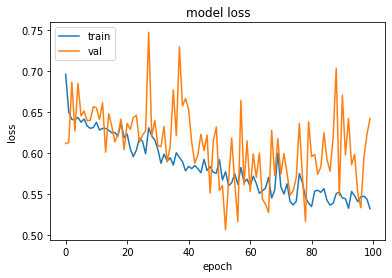

In [84]:
CAE_autoencoder.save('autoencoder_extra_epochs.h5')
with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history_CAE.history, file_pi)
plt.plot(history_CAE.history['loss'])
plt.plot(history_CAE.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [79]:
history_CAE.history.keys()

dict_keys(['loss', 'CAE_decoder_loss', 'CAE_classifier_loss', 'CAE_decoder_mae', 'CAE_classifier_acc', 'CAE_classifier_precision_5', 'CAE_classifier_recall_5', 'CAE_classifier_false_negatives_5', 'CAE_classifier_false_positives_5', 'val_loss', 'val_CAE_decoder_loss', 'val_CAE_classifier_loss', 'val_CAE_decoder_mae', 'val_CAE_classifier_acc', 'val_CAE_classifier_precision_5', 'val_CAE_classifier_recall_5', 'val_CAE_classifier_false_negatives_5', 'val_CAE_classifier_false_positives_5'])

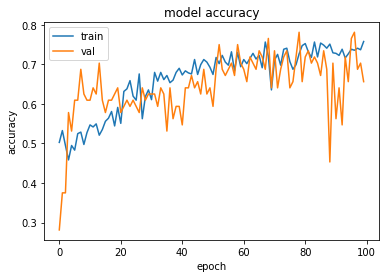

In [85]:
#CAE_autoencoder.save('autoencoder_100epochs.h5')

plt.plot(history_CAE.history['CAE_classifier_acc'])
plt.plot(history_CAE.history['val_CAE_classifier_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

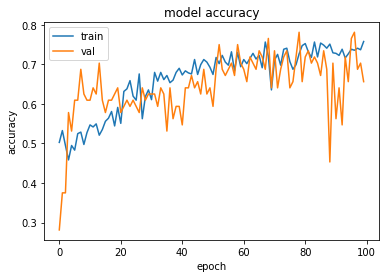

In [86]:
#CAE_autoencoder.save('autoencoder_100epochs.h5')

plt.plot(history_CAE.history['CAE_classifier_precision_5'])
plt.plot(history_CAE.history['val_CAE_classifier_precision_5'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
balancing_weights_val = class_weight.compute_sample_weight('balanced',val_label)
val_generator = MyDataGenerator(val_list, processed_dir,to_fit=False, batch_size=2,sample_weight=balancing_weights_val)
pred = CAE_autoencoder.predict_generator(val_generator)

In [103]:
from sklearn.metrics import classification_report,accuracy_score
print("acc: ",accuracy_score(labels_to_categorical(val_label),np.round(pred[1])))
print(classification_report(labels_to_categorical(val_label),np.round(pred[1])))

acc:  0.5918367346938775
              precision    recall  f1-score   support

           0       0.45      0.47      0.46        36
           1       0.68      0.66      0.67        62

   micro avg       0.59      0.59      0.59        98
   macro avg       0.57      0.57      0.57        98
weighted avg       0.60      0.59      0.59        98
 samples avg       0.59      0.59      0.59        98



In [0]:
with open('/trainHistoryDict', 'rb') as file_pi:
  test = pickle.load(file_pi)

In [113]:
test['loss']

[0.6959508061408997,
 0.6500263810157776,
 0.6410303115844727,
 0.6404862403869629,
 0.6433345675468445,
 0.6376724243164062,
 0.6414902806282043,
 0.6329331994056702,
 0.6301970481872559,
 0.6310799717903137,
 0.6375556588172913,
 0.6281263828277588,
 0.629970371723175,
 0.6301645040512085,
 0.6277721524238586,
 0.6248348355293274,
 0.6250298023223877,
 0.6206368207931519,
 0.6374790668487549,
 0.6188066601753235,
 0.6233232617378235,
 0.6055681109428406,
 0.5956369638442993,
 0.6035904288291931,
 0.6183918118476868,
 0.6143094897270203,
 0.5991983413696289,
 0.6307562589645386,
 0.6205859780311584,
 0.6160404086112976,
 0.6043842434883118,
 0.5876139998435974,
 0.5988029837608337,
 0.5903701186180115,
 0.5943551063537598,
 0.5855919718742371,
 0.6004462242126465,
 0.5946162939071655,
 0.5895824432373047,
 0.5783635973930359,
 0.5838564038276672,
 0.5811471939086914,
 0.584901750087738,
 0.5809565186500549,
 0.5762155055999756,
 0.5923739671707153,
 0.5787504315376282,
 0.583589375019

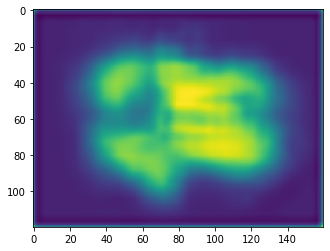

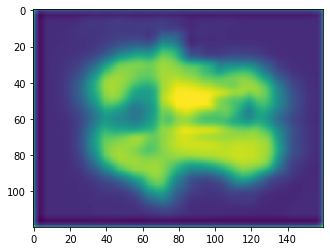

In [136]:
plt.imshow(pred[0][2][:,:,15,0])
plt.show()
plt.imshow(pred[0][2][:,:,0,0])